In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import pytesseract
import argparse
import cv2
import os
import numpy as np
import math
from shutil import copy
import imutils
from preprocessing_image import PreprocesingImage
import re
import datetime
from dateutil.relativedelta import relativedelta

2019-10-04 01:41:55,777 : DEBUG : Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
src = 'pretrained_model/vie.traineddata'
dst = '/usr/share/tesseract/tessdata'
copy(src, dst)

'/usr/share/tesseract/tessdata/vie.traineddata'

In [3]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [4]:
img = cv2.imread('../image/cccd/DTN_Shot.jpg', cv2.IMREAD_GRAYSCALE)

# thres, thres_img = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(img.shape)

(1811, 2561)


In [5]:
path = "../image/"
image_path = path + 'cccd/DTN_CCCD_Shot_Error_OCR_1.jpg'
# image_path = path + 'cccd/DTN_CCCD_Shot_Error_5.jpg'
# image_path = path + 'cccd/NDMT_CCCD.jpg'
# image_path = path + 'cccd/NDMT_CCCD_Error.jpg'
# image_path = path + 'cccd/NDMT_CCCD_Error_3.jpg'

2019-10-04 01:41:56,269 : INFO : Copy edges to the images that will display the results in BGR
2019-10-04 01:41:56,412 : DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2019-10-04 01:41:56,414 : DEBUG : findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
2019-10-04 01:41:56,415 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold normal>) = 10.335
2019-10-04 01:41:56,417 : DEBUG : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2019-10-04 01:41:56,418 : DEBUG : findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
2019-10-04 01:41:56,420 : DEBUG : findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
2019-10-04 01:41:56,421 : DEBUG : findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique norm

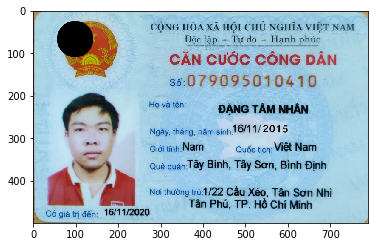

In [6]:
# corner_arr = np.asarray(pts_corner, dtype = "float32")
# warped_orig = four_point_transform(img_scale, corner_arr)
warped_image = PreprocesingImage.crop_card(image_path, 500)
warped_orig = PreprocesingImage.scale_image_with_image(warped_image, 500)
show_image(warped_orig)

# Prepocessing image then apply tesseract

In [7]:
# Sharpened the images
def unsharp_mask(image, kernel_size, sigma, amount, threshold):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

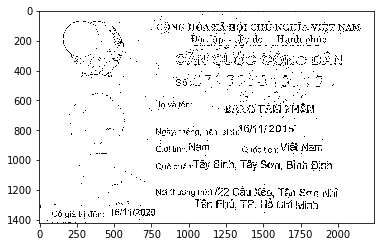

In [8]:
warped = cv2.cvtColor(warped_image, cv2.COLOR_BGR2GRAY)
thres_img = cv2.adaptiveThreshold(warped,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,13,13)
show_image(thres_img)

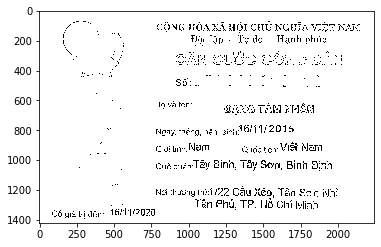

In [9]:
blur = cv2.medianBlur(thres_img,5)
show_image(blur)

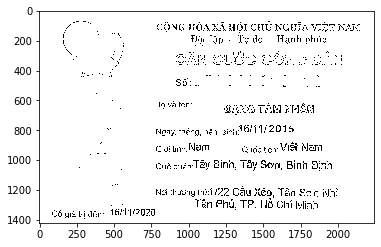

In [10]:
sharpened = unsharp_mask(blur, (5,5), 150, 50, 150)
show_image(sharpened)

# Calculate histogram then group them. Only used for part where most information reside and have no actual standard format. Ignore this part for now

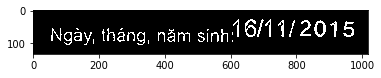

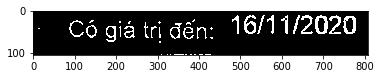

In [11]:
# If some information is missing, changing the ratio
bin_img = ~sharpened

ratio_x_1 = 2.7/8.6
ratio_x_2 = 3.1/8.6
ratio_y_1 = 1.5/5.4
ratio_y_2 = 5.035/5.4
ratio_y_3 = 5.0/5.4

ratio_x_dob_beg = 2.8/8.6
ratio_x_dob_end = 6.7/8.6

ratio_y_dob_beg = 2.8/5.4
ratio_y_dob_end = 3.3/5.4

# part_1 = bin_img[int(bin_img.shape[0]*ratio_y_1):int(bin_img.shape[0]*ratio_y_2),
#                  int(bin_img.shape[1]*ratio_x_1):]

part_1 = bin_img[int(bin_img.shape[0]*ratio_y_dob_beg):int(bin_img.shape[0]*ratio_y_dob_end),
                 int(bin_img.shape[1]*ratio_x_dob_beg):int(bin_img.shape[1]*ratio_x_dob_end)]
                                                          
part_2 = bin_img[int(bin_img.shape[0]*ratio_y_3):,
                 :int(bin_img.shape[1]*ratio_x_2)]

show_image(part_1)
show_image(part_2)
now_time = datetime.datetime.now()

In [12]:
def check_birthday(birthday):
    enough_14 = birthday + relativedelta(years=+14)
    enough_18 = birthday + relativedelta(years=+18)
    now_time = datetime.datetime.now()
    if now_time < enough_14:
        return False, "It isn't enough age to have identity card!!!"
    elif now_time < enough_18:
        return False, "It isn't enough age to get loan!!"
    else:
        return True, ""

In [13]:
def check_expiration_date(expiration_date):
    now_time = datetime.datetime.now()
    if now_time > expiration_date:
        return False, "Your identity card has expired!!!"
    else:
        return True, ""

In [30]:
def denote_face(image, sub_image, color=(255, 0, 0),thickness = 3):
    """ function to denote location of face on image """
    img = image.copy()
    for (x, y, w, h) in face:
        cv.rectangle(img, (x, y), (x + w, y + h), color, thickness)

    return img

Ngéy, théng, ném sinhz16/11/2015
False
It isn't enough age to have identity card!!!


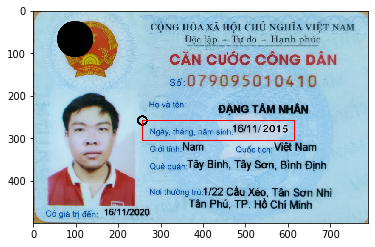

In [69]:
# For part 2 just simply apply tesseract provided the image is clear enough
text = pytesseract.image_to_string(~part_1, lang = 'eng',config='-psm 6')
print(text)
m = re.findall("([\/0-9]+)", text)
if m:
    bod = m[-1]
    bod.replace(" ", "")
    bod_finally = bod[len(bod)-10:len(bod)]
    bod_date = datetime.datetime.strptime(bod_finally, "%d/%m/%Y")
    status_bod_date, message_bod_date = check_birthday(bod_date)
    print(status_bod_date)
    print(message_bod_date)
    result_image = warped_image.copy()
    image_resize = imutils.resize(warped_image.copy(), height=500)
    ratio = result_image.shape[0] / 500.0
    x_1 = int(bin_img.shape[1]*ratio_x_dob_beg / ratio)
    y_1 = int(bin_img.shape[0]*ratio_y_dob_beg / ratio)
    x_2 = int(bin_img.shape[1]*ratio_x_dob_end / ratio)
    y_2 = int(bin_img.shape[0]*ratio_y_dob_end / ratio)
    cv2.circle(image_resize, (x_1, y_1), 10, (0,0,0), 3)
    cv2.rectangle(image_resize, (x_1,y_1), (x_2,y_2),(255, 0, 0), 2)
    show_image(image_resize)
else:
    print("Cannot found")

Co giatridénz16/11/2020
2020-11-16 00:00:00
True



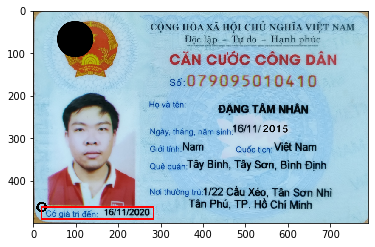

In [75]:
# For part 2 just simply apply tesseract provided the image is clear enough
text = pytesseract.image_to_string(~part_2, lang='eng', config='--psm 6')
print(text)
m = re.findall("([/0-9]+)", text)
if m:
    exp = m[-1]
    exp.replace(" ", "")
    exp_finally = exp[len(exp) - 10:len(exp)]
    exp_date = datetime.datetime.strptime(exp_finally, "%d/%m/%Y")
    status_exp_date, message_exp_date = check_expiration_date(exp_date)
    print(exp_date)
    print(status_exp_date)
    print(message_exp_date)
    result_image = warped_image.copy()
    image_resize = imutils.resize(warped_image.copy(), height=500)
    ratio = result_image.shape[0] / 500.0    
    x_1 = 20
    y_1 = int(bin_img.shape[0] * ratio_y_3 / ratio)
    x_2 = int(bin_img.shape[1] * ratio_x_2 / ratio)
    y_2 = int(bin_img.shape[0] / ratio) - 10
    cv2.rectangle(image_resize, (x_1,y_1), (x_2,y_2),(255, 0, 0), 2)
    show_image(image_resize)
#     return status_exp_date, message_exp_date

In [16]:
if not status_exp_date or not status_bod_date:
    message_ocr = message_bod_date + " " + message_exp_date
    print(False)
    print(message_ocr)
#     return False, message_ocr
else:
    print(True)
#     return True, ""

False
It isn't enough age to have identity card!!! 
